In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf

from dirichlet import mle
from src.models.synthesis.wgan import MLPCritic, MLPGenerator, CustomHistory
from src.models.synthesis.wgan.wgan import WGANGP, critic_loss, generator_loss
from src.utils.constants import FEATURES_NAMES

### Wasserstein GAN

In [2]:
# WGAN #9 params
#
#       hidden layers: [64, 64, 64]
#       activation: relu
#       latent dim: 16
#
#       lr: 0.0001
#       beta_1: 0.5
#       beta_2: 0.9
#       lambda: 10.0
#       n_critic: 5
#       epochs: int(1e4)
#       batch_size: 32
#
model_name = "WGAN #8"

hidden_units = [64, 64, 64]
latent_dim = 16

lambda_ = 10.0
n_critic = 5
lr = 0.0001
beta_1, beta_2 = 0.5, 0.9
batch_size = 32
epochs = 500

dataset_path = os.path.join("data", "processed", "thermo_processed_data.csv")
train_features = pd.read_csv(dataset_path)[FEATURES_NAMES[:-2]]

train_features = train_features.drop_duplicates(subset=FEATURES_NAMES[:-2], ignore_index=True)
train_features[FEATURES_NAMES[:-2]] = train_features[FEATURES_NAMES[:-2]] / 100.0

output_dim = train_features.shape[-1]

data = train_features.values.astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

critic = MLPCritic(hidden_units=hidden_units)
generator = MLPGenerator(output_dim=output_dim, hidden_units=hidden_units)

critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)

# Get the Wasserstein GAN model
wgan = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=latent_dim,
    n_critic=n_critic,
    lambda_=lambda_,
)

# Compile the Wasserstein GAN model
wgan.compile(
    critic_optimizer=critic_optimizer,
    generator_optimizer=generator_optimizer,
    critic_loss_fn=critic_loss,
    generator_loss_fn=generator_loss,
)

callbacks = [CustomHistory()]
wgan.fit(dataset, epochs=epochs, callbacks=callbacks, verbose=1)

neg_critic_loss = -np.array(callbacks[0].history["critic_loss"])

model_folder = os.path.join("data", "models", "synthesis", "saved_models", model_name)
generator.save(os.path.join(model_folder, "final_generator.keras"))

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - critic_loss: 2.5592 - generator_loss: 0.0467
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - critic_loss: 0.1625 - generator_loss: 0.0969
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - critic_loss: -0.0856 - generator_loss: 0.1178
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - critic_loss: -0.1949 - generator_loss: 0.1334
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - critic_loss: -0.2911 - generator_loss: 0.1473
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - critic_loss: -0.3515 - generator_loss: 0.1591
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - critic_loss: -0.3654 - generator_loss: 0.1776
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - critic_loss: -0.3688 - generator_loss: 0.1822 
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - critic_loss: -0.3530 - generator_loss: 0.1668 
Epoch 10/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - critic_loss: -0.3104 - generator_loss: 0.1477 
Epoch 1

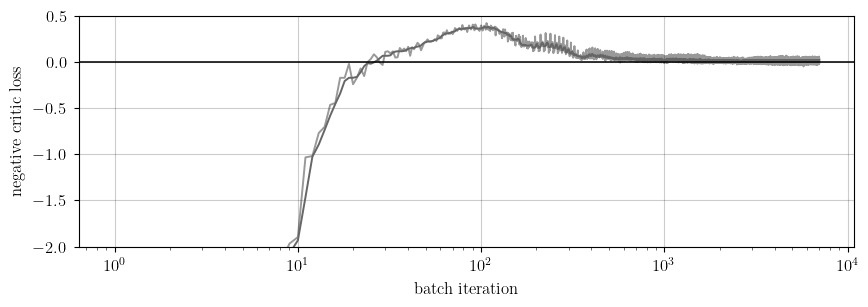

In [3]:
batches = neg_critic_loss.shape[0]

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(batches), neg_critic_loss, alpha=0.4)
ax.plot(np.arange(batches), pd.Series(neg_critic_loss).rolling(10, center=True).median())
ax.set_xlabel("batch iteration")
ax.set_ylabel("negative critic loss")
ax.set_ylim([-2, 0.5])
ax.axhline(y=0.0, color=("black", 0.8), linestyle="-")
ax.grid()

# ax.set_yscale('log')
ax.set_xscale("log")
plt.show()

### Dirichlet MLE

In [4]:
model_name = "Dirichlet Estimator"

def save_pickle(filepath, obj):
    with open(filepath, "wb") as f:
        pickle.dump(obj, f)

dataset_path = os.path.join("data", "processed", "thermo_processed_data.csv")
train_features = pd.read_csv(dataset_path)[FEATURES_NAMES[:-2]]

train_features = train_features.drop_duplicates(subset=FEATURES_NAMES[:-2], ignore_index=True)
train_features[FEATURES_NAMES[:-2]] = train_features[FEATURES_NAMES[:-2]] / 100.0

alpha = mle(train_features.values)

model_folder = os.path.join("data", "models", "synthesis", "saved_models", model_name)
save_pickle(os.path.join(model_folder, "final_alpha.pickle"), alpha)